In [10]:
# merge samples, two input must be same shape
inp1 = Input(shape=(10,32))
inp2 = Input(shape=(10,32))
cc1 = concatenate([inp1, inp2],axis=0) # Merge data must same row column
output = Dense(30, activation='relu')(cc1)
model = Model(inputs=[inp1, inp2], outputs=output)
model.summary()

# merge row must same column size
inp1 = Input(shape=(20,10))
inp2 = Input(shape=(32,10))
cc1 = concatenate([inp1, inp2],axis=1)
output = Dense(30, activation='relu')(cc1)
model = Model(inputs=[inp1, inp2], outputs=output)
model.summary()

# merge column must same row size
inp1 = Input(shape=(10,20))
inp2 = Input(shape=(10,32))
cc1 = concatenate([inp1, inp2],axis=1)
output = Dense(30, activation='relu')(cc1)
model = Model(inputs=[inp1, inp2], outputs=output)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 10, 32)       0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 10, 32)       0                                            
__________________________________________________________________________________________________
concatenate_11 (Concatenate)    (None, 10, 32)       0           input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 10, 30)       990         concatenate_11[0][0]       

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 10, 20), (None, 10, 32)]

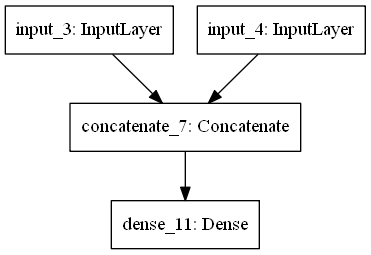

In [8]:
plot_model(model,to_file='model测试.png')

In [1]:
import tensorflow as tf
from tensorflow.python.tools import saved_model_utils
from tensorflow.python.framework import graph_util
from tensorflow.python.saved_model import tag_constants

with tf.Graph().as_default() as g1:
  base64_str = tf.placeholder(tf.string, name='input_string')
  input_str = tf.decode_base64(base64_str)
  decoded_image = tf.image.decode_png(input_str, channels=1)
  # Convert from full range of uint8 to range [0,1] of float32.
  decoded_image_as_float = tf.image.convert_image_dtype(decoded_image,
                                                        tf.float32)
  decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
  resize_shape = tf.stack([28, 28])
  resize_shape_as_int = tf.cast(resize_shape, dtype=tf.int32)
  resized_image = tf.image.resize_bilinear(decoded_image_4d,
                                           resize_shape_as_int)
  # 展开为1维数组
  resized_image_1d = tf.reshape(resized_image, (-1, 28 * 28))
  print(resized_image_1d.shape)
  tf.identity(resized_image_1d, name="DecodeJPGOutput")

g1def = g1.as_graph_def()

with tf.Graph().as_default() as g2:
  with tf.Session(graph=g2) as sess:
    input_graph_def = saved_model_utils.get_meta_graph_def(
        "./model", tag_constants.SERVING).graph_def

    tf.saved_model.loader.load(sess, ["serve"], "./model")

    g2def = graph_util.convert_variables_to_constants(
        sess,
        input_graph_def,
        ["myOutput"],
        variable_names_whitelist=None,
        variable_names_blacklist=None)

with tf.Graph().as_default() as g_combined:
  with tf.Session(graph=g_combined) as sess:

    x = tf.placeholder(tf.string, name="base64_input")

    y, = tf.import_graph_def(g1def, input_map={"input_string:0": x}, return_elements=["DecodeJPGOutput:0"])

    z, = tf.import_graph_def(g2def, input_map={"myInput:0": y}, return_elements=["myOutput:0"])
    tf.identity(z, "myOutput")

    tf.saved_model.simple_save(sess,
              "./modelbase64",
              inputs={"base64_input": x},
              outputs={"myOutput": z})

(1, 784)


OSError: SavedModel file does not exist at: ./model